In [1]:
import gc
import os

import pandas as pd

import torch
import numpy as np
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.model_selection import train_test_split
from torch.nn.functional import normalize
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import uci_dataset as dataset

In [2]:
def to_torch(X, d_type: torch.dtype):
    m, n = X.shape[0], X.shape[1]
    X_inner = torch.tensor(X, dtype=d_type)

    X_prime = normalize(torch.cat(
        [X_inner, torch.ones(m, dtype=d_type).reshape(-1, 1)], dim=1
    ), p=2, dim=1)
    return X_prime

In [3]:
def kronecker(a: torch.Tensor, b: torch.Tensor):
    return torch.einsum('na,nb->nab', a, b).view(a.size(0), a.size(1) * b.size(1))

In [4]:
if not os.path.exists('./hd_output'):
        os.mkdir('./hd_output')

In [5]:
names = np.zeros(14)
for i in range(14):
    names[i] = i

data = pd.read_csv('cleveland.data', names = names)

data = data.replace("?", np.nan)

label = np.zeros(303)

for i in range(303):
    if data[13.0][i] == 0:
        label[i] = 0
    else:
        label[i] = 1
        
data['label'] = label



In [6]:
data=data.dropna()
data=data.dropna(axis=0)
data=data.dropna().reset_index(drop=True)
display(data)
data.to_csv(f'./hd_output/raw.csv')

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,label
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1,1.0
293,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1.0
294,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1.0
295,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1.0


In [7]:
y = data['label'].values
X = data.drop('label', axis = 1).values
X = X.astype(float)
print(X.dtype)

float64


In [8]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64

    y = data['label'].values
    X = data.drop('label', axis = 1).values
    X = X.astype(float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=539232944)
   
    X_prime = to_torch(X_train, d_type=d_type)
    
    test_class = 0
    test_no = 1
    X_test_prime = to_torch(X_test[y_test == test_class], d_type=d_type)

    max_copies = 100
    result = []
    for copies in range(1, max_copies + 1):
        c = X_test_prime[0]
        result_sum = 0
        result_sum_fid = 0
        for a_index in range(X_prime[y_train == 0].shape[0]):
            for b_index in range(X_prime[y_train == 1].shape[0]):
                a = X_prime[y_train == 0][a_index]
                b = X_prime[y_train == 1][b_index]

                inner_product_ab: torch.Tensor = torch.matmul(a, b)
                inner_product_ca: torch.Tensor = torch.matmul(c, a)
                inner_product_cb: torch.Tensor = torch.matmul(c, b)
                overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                contrib_ca = np.power(overlap_ca, copies)
                contrib_cb = np.power(overlap_cb, copies)

                result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                result_ab_fid = contrib_ca - contrib_cb
                result_sum += result_ab
                result_sum_fid += result_ab_fid
                
    
        result_sum = result_sum / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
        result_sum_fid = result_sum_fid / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
            
        df_copies = pd.DataFrame(
            data=[[copies, result_sum, result_sum_fid]],
            columns=['Copies', 'Helstrom sim', 'Fidelity sim']
        )
        result.append(df_copies)
        df = pd.concat(result)

df.to_csv(f'./hd_output/hd_score_copies_{max_copies}.csv')   

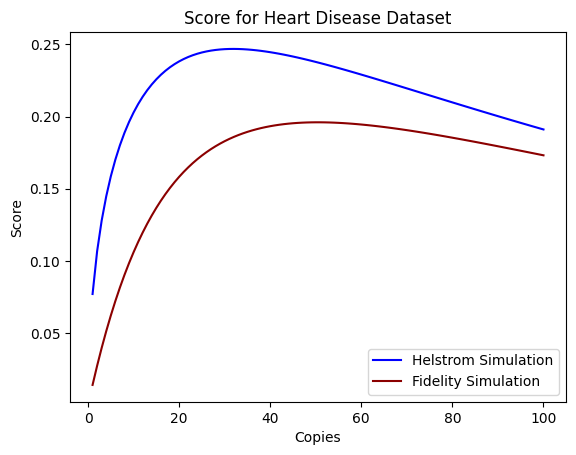

In [9]:
df = pd.read_csv(f'./hd_output/hd_score_copies_{max_copies}.csv')
fig: Figure = plt.figure()
ax: Axes = fig.subplots()
df.plot(x='Copies', y='Helstrom sim', kind='line', ax=ax, label='Helstrom Simulation', color='blue')
df.plot(x='Copies', y='Fidelity sim', kind='line', ax=ax, label='Fidelity Simulation', color='darkred')
ax.set_ylabel('Score')
plt.legend()
plt.title('Score for Heart Disease Dataset')
plt.savefig(f'./hd_output/score_test_{test_class}_{max_copies}.png')
plt.savefig(f'./hd_output/score_test_{test_class}_{max_copies}.pdf')
plt.show()

In [10]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64


    y = data['label'].values
    X = data.drop('label', axis = 1).values
    X = X.astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)

    X_prime = to_torch(X_train, d_type=d_type)

    test_no = 10
    X_test_prime = to_torch(X_test, d_type=d_type)

    copies = 2
    result_sum = torch.zeros(X_test_prime.shape[0])
    result_sum_fid = torch.zeros(X_test_prime.shape[0])
    
    for i in range(X_test_prime.shape[0]):
        c = X_test_prime[i] 
        for a_index in range(X_prime[y_train == 0].shape[0]):
            for b_index in range(X_prime[y_train == 1].shape[0]):
                a = X_prime[y_train == 0][a_index]
                b = X_prime[y_train == 1][b_index]

                inner_product_ab: torch.Tensor = torch.matmul(a, b)
                inner_product_ca: torch.Tensor = torch.matmul(c, a)
                inner_product_cb: torch.Tensor = torch.matmul(c, b)
                overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                contrib_ca = np.power(overlap_ca, copies)
                contrib_cb = np.power(overlap_cb, copies)

                result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                result_ab_fid = contrib_ca - contrib_cb
                result_sum[i] += result_ab
                result_sum_fid[i] += result_ab_fid
                
    
result_sum = result_sum / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
result_sum_fid = result_sum_fid / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])

In [11]:
df_2 = pd.DataFrame(np.asarray([
            result_sum.numpy().T,
            result_sum_fid.numpy(),
            y_test
        ]).T, columns=['result_sum', 'result_sum_fid', 'y_test'])
df_2.to_csv(f'./hd_output/classification_test_copies_{copies}.csv')


In [12]:
copies = 2
df_2 = pd.read_csv(f'./hd_output/classification_test_copies_{copies}.csv')
result_sum = df_2['result_sum']
result_sum_fid = df_2['result_sum_fid']


hel_pred = np.zeros(X_test_prime.shape[0])
fid_pred = np.zeros(X_test_prime.shape[0])

for i in range(X_test_prime.shape[0]):
    if result_sum[i] > 0:
        hel_pred[i] = 0
    else:
        hel_pred[i] = 1

for i in range(X_test_prime.shape[0]):
    if result_sum_fid[i] > 0:
        fid_pred[i] = 0
    else:
        fid_pred[i] = 1

print("helstrom for copies:{:} \n".format(copies))        
print(metrics.classification_report(y_test, hel_pred, digits=3))
print(metrics.confusion_matrix(y_test, hel_pred))

print("helstrom for copies:{:} \n".format(copies))        
print(metrics.classification_report(y_test, fid_pred, digits=3))
print(metrics.confusion_matrix(y_test, fid_pred))

helstrom for copies:2 

              precision    recall  f1-score   support

         0.0      0.710     0.667     0.688        33
         1.0      0.621     0.667     0.643        27

    accuracy                          0.667        60
   macro avg      0.665     0.667     0.665        60
weighted avg      0.670     0.667     0.667        60

[[22 11]
 [ 9 18]]
helstrom for copies:2 

              precision    recall  f1-score   support

         0.0      0.677     0.636     0.656        33
         1.0      0.586     0.630     0.607        27

    accuracy                          0.633        60
   macro avg      0.632     0.633     0.632        60
weighted avg      0.636     0.633     0.634        60

[[21 12]
 [10 17]]


In [25]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64


    y = data['label'].values
    X = data.drop('label', axis = 1).values
    X = X.astype(float)

    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)

    X_prime = to_torch(X_train, d_type=d_type)

    test_no = 10
    X_test_prime = to_torch(X_test, d_type=d_type)

    copies = 50
    result_sum = torch.zeros(X_test_prime.shape[0])
    result_sum_fid = torch.zeros(X_test_prime.shape[0])
    
    for i in range(X_test_prime.shape[0]):
        c = X_test_prime[i] 
        for a_index in range(X_prime[y_train == 0].shape[0]):
            for b_index in range(X_prime[y_train == 1].shape[0]):
                a = X_prime[y_train == 0][a_index]
                b = X_prime[y_train == 1][b_index]

                inner_product_ab: torch.Tensor = torch.matmul(a, b)
                inner_product_ca: torch.Tensor = torch.matmul(c, a)
                inner_product_cb: torch.Tensor = torch.matmul(c, b)
                overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                contrib_ca = np.power(overlap_ca, copies)
                contrib_cb = np.power(overlap_cb, copies)

                result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                result_ab_fid = contrib_ca - contrib_cb
                result_sum[i] += result_ab
                result_sum_fid[i] += result_ab_fid
                
    
result_sum = result_sum / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
result_sum_fid = result_sum_fid / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])

In [13]:
if __name__ == '__main__':
    torch.set_printoptions(linewidth=10000, precision=2, sci_mode=False, threshold=10000)
    torch.set_num_threads(8)

    d_type = torch.float64

    y = data['label'].values
    X = data.drop('label', axis = 1).values
    X = X.astype(float)
    X_train, X_test, y_train, y_test = train_test_split(X[y != 2], y[y != 2],
                                                        test_size=0.2, random_state=539232944)
    X_prime = to_torch(X_train, d_type=d_type)

    test_class = 0
    test_no = 1
    X_test_prime = to_torch(X_test, d_type=d_type)


    max_copies = 30
    result_sum = torch.zeros(X_test_prime.shape[0])
    result_sum_fid = torch.zeros(X_test_prime.shape[0])
    accuracy = torch.zeros(max_copies)
    accuracy_fid = torch.zeros(max_copies)
    
    for copies in range(1,max_copies+1):
        for i in range(X_test_prime.shape[0]):
            c = X_test_prime[i] 
            for a_index in range(X_prime[y_train == 0].shape[0]):
                for b_index in range(X_prime[y_train == 1].shape[0]):
                    a = X_prime[y_train == 0][a_index]
                    b = X_prime[y_train == 1][b_index]

                    inner_product_ab: torch.Tensor = torch.matmul(a, b)
                    inner_product_ca: torch.Tensor = torch.matmul(c, a)
                    inner_product_cb: torch.Tensor = torch.matmul(c, b)
                    overlap_ab = float(inner_product_ab * torch.conj(inner_product_ab))
                    overlap_ca = float(inner_product_ca * torch.conj(inner_product_ca))
                    overlap_cb = float(inner_product_cb * torch.conj(inner_product_cb))

                    lambda_ab = np.sqrt(1 - np.power(overlap_ab, copies))
                    contrib_ca = np.power(overlap_ca, copies)
                    contrib_cb = np.power(overlap_cb, copies)
    
                    result_ab = 1/lambda_ab * (contrib_ca - contrib_cb)
                    result_ab_fid = contrib_ca - contrib_cb
                    result_sum[i] += result_ab
                    result_sum_fid[i] += result_ab_fid
            
            result_sum[i] = result_sum[i] / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
            result_sum_fid[i] = result_sum_fid[i] / (X_prime[y_train == 0].shape[0] * X_prime[y_train == 1].shape[0])
            
            
            if result_sum[i] > 0:
                result_sum[i] = 0
            else:
                result_sum[i] = 1
            
            if result_sum_fid[i] > 0:
                result_sum_fid[i] = 0
            else:
                result_sum_fid[i] = 1
    
        
        accuracy[copies-1] = metrics.accuracy_score(y_test, result_sum, normalize=True, sample_weight=None)
        accuracy_fid[copies-1] = metrics.accuracy_score(y_test, result_sum_fid, normalize=True, sample_weight=None)

In [14]:
copies = torch.zeros(max_copies)
for i in range(max_copies):
    copies[i] = i+1

d = {'copies' : copies, 'accuracy' : accuracy, 'accuracy_fid': accuracy_fid}
df = pd.DataFrame(data = d)
df.to_csv(f'./hd_output/hd_accuracy_copies_{max_copies}.csv') 

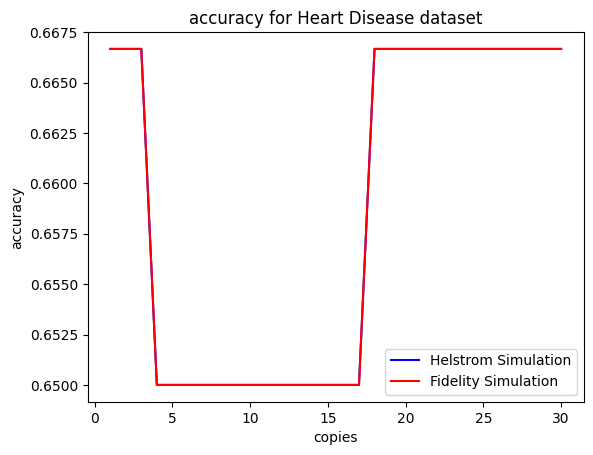

In [16]:
df = pd.read_csv(f'./hd_output/hd_accuracy_copies_{max_copies}.csv')
fig: Figure = plt.figure()
ax: Axes = fig.subplots()
df.plot(x='copies', y='accuracy', kind='line', ax=ax, label='Helstrom Simulation', color='blue')
df.plot(x='copies', y='accuracy', kind='line', ax=ax, label='Fidelity Simulation', color='red')
ax.set_ylabel('accuracy')
plt.legend()
plt.title("accuracy for Heart Disease dataset")
plt.savefig(f'./hd_output/hep_accuracy_test_{max_copies}.png')
plt.savefig(f'./hd_output/hep_accuracy_test_{max_copies}.pdf')
plt.show()